# Setup

In [ ]:
#@title Carregando as bibliotecas base
import pandas as pd
import numpy as np
import tensorflow as tf

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style('whitegrid')

In [ ]:
#@title Carregando os dados
data = pd.read_csv(f'/content/drive/My Drive/Mestrado/data/dados_treino_teste.csv.gz', compression='gzip', index_col=0)
data.head()

,codigo,mercado,preco_opcao,preco_exercicio,data_vencimento,T,preco_ativo,volatilidade,taxa_juros,black_scholes,delta_black_scholes,base
2015-01-05,PETRM17,OPÇÕES DE VENDA,8.18,16.91,2015-01-19,0.039683,8.61,0.771953,0.1157,8.22,100,treino
2015-01-05,PETRM28,OPÇÕES DE VENDA,0.36,8.41,2015-01-19,0.039683,8.61,0.771953,0.1157,0.41,40,treino
2015-01-05,PETRM2,OPÇÕES DE VENDA,0.02,4.91,2015-01-19,0.039683,8.61,0.771953,0.1157,0.00,0,teste
2015-01-05,PETRM23,OPÇÕES DE VENDA,0.79,9.21,2015-01-19,0.039683,8.61,0.771953,0.1157,0.87,63,treino
2015-01-05,PETRM25,OPÇÕES DE VENDA,1.13,9.61,2015-01-19,0.039683,8.61,0.771953,0.1157,1.16,73,treino


In [ ]:
data_padded = pd.read_csv('/content/drive/My Drive/Mestrado/data/dados_padded_max_treino_teste.csv.gz', compression='gzip')
timestep_length = 341

# Engenharia das variáveis (Feature Engineering)

Essa sessão é composta da transformação dos dados para entrada na rede na rede neural. Portando, as variáveis são transformadas do seu valor original, seja para adequação dentro da rede neural ou para um melhor treinamento da rede, essas transformações são:

- Variavéis númericas foram normalizadas antes da entrada na rede
- Variável categórica sofreu one hot encoding

A transformação dos dados é feita no mesmo momento que o modelo é treinado, isso é feito através da criacão de um modelo que não diferenciado numéricamente e vai somente processar os dados de entrada. 

In [ ]:
#@title Definir subset para o modelo
cols = ['preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros', 'mercado', 'preco_opcao']
features = data[cols].copy()
labels = features.pop('preco_opcao')

In [ ]:
#@title Definir variáveis de entrada
inputs = {}

for name, column in features.items():
    dtype = column.dtype
    if dtype == object:
        dtype = tf.string
    else:
        dtype = tf.float32

    inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

In [ ]:
#@title Definir variáveis númericas e normalizar
numeric_inputs = {name: input for name, input in inputs.items() if input.dtype==tf.float32}

x = tf.keras.layers.Concatenate(name='concatenate_numeric')(list(numeric_inputs.values()))
norm = tf.keras.layers.experimental.preprocessing.Normalization()
norm.adapt(np.array(data[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

preprocessed_inputs = [all_numeric_inputs]

In [ ]:
#@title Definir categóricas e aplicar one hot encoding
for name, input in inputs.items():
    if input.dtype == tf.float32:
        continue
  
    lookup = tf.keras.layers.experimental.preprocessing.StringLookup(vocabulary=np.unique(features[name]))
    one_hot = tf.keras.layers.experimental.preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

    x = lookup(input)
    x = one_hot(x)
    preprocessed_inputs.append(x)

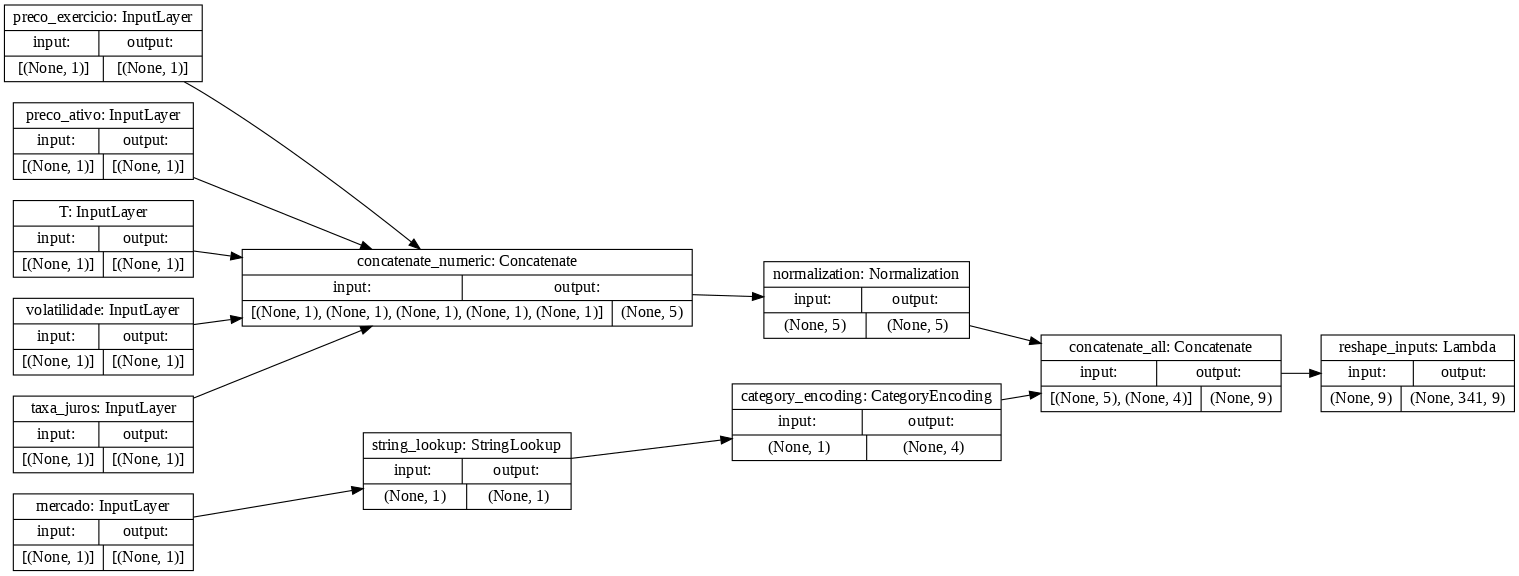

In [ ]:
#@title Concatenar dados de entrada e criar modelo para processamento das variavéis
preprocessed_inputs_concat = tf.keras.layers.Concatenate(name='concatenate_all')(preprocessed_inputs)
reshape_inputs = tf.keras.layers.Lambda(lambda x: tf.reshape(x, (-1, timestep_length, preprocessed_inputs_concat.shape[1])), name='reshape_inputs')(preprocessed_inputs_concat)
model_preprocessing_input = tf.keras.Model(inputs, reshape_inputs)
tf.keras.utils.plot_model(model=model_preprocessing_input, rankdir="LR", dpi=80, show_shapes=True)

In [ ]:
#@title Amostra de dados processados
sample_features_dict = {name: np.array(value) for name, value in features.items()}
sample_features_dict = {name: values[:timestep_length] for name, values in sample_features_dict.items()}
model_preprocessing_input(sample_features_dict)

<tf.Tensor: shape=(1, 341, 9), dtype=float32, numpy=
array([[[-0.16609144, -1.262118  , -0.5997047 , ...,  0.        ,
          0.        ,  1.        ],
        [-1.2128178 , -1.262118  , -0.5997047 , ...,  0.        ,
          0.        ,  1.        ],
        [-1.6438228 , -1.262118  , -0.5997047 , ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [-0.7202407 , -1.3005961 , -0.2999    , ...,  0.        ,
          1.        ,  0.        ],
        [-1.0170184 , -1.3005961 ,  4.989511  , ...,  0.        ,
          1.        ,  0.        ],
        [-0.8938741 , -1.3005961 ,  4.989511  , ...,  0.        ,
          1.        ,  0.        ]]], dtype=float32)>

In [ ]:
#@title tf.Data
def df_to_dataset(dataframe, base, batch_size, timesteps):

    dataframe = dataframe.copy()
    dataframe = dataframe[dataframe['base'] == base]
    labels = dataframe.pop('preco_opcao')
    cols = ['mercado', 'preco_exercicio', 'preco_ativo', 'T', 'volatilidade', 'taxa_juros']
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe[cols]), labels))
    ds = ds.batch(batch_size*timesteps)

    def reshape_labels(data, labels):
        return data, tf.reshape(labels, (-1, timestep_length, 1))

    ds = ds.map(reshape_labels)
    # ds = ds.map(lambda data, labels: tf.reshape(labels, (-1, timestep_length, 1)))
    return ds

# Tamanho do batch
batch_size = 64

# Divisão da base de treino e teste
train_ds = df_to_dataset(data_padded, batch_size=batch_size, timesteps=timestep_length, base='treino')
test_ds = df_to_dataset(data_padded, batch_size=batch_size, timesteps=timestep_length, base='teste')

# Modelo

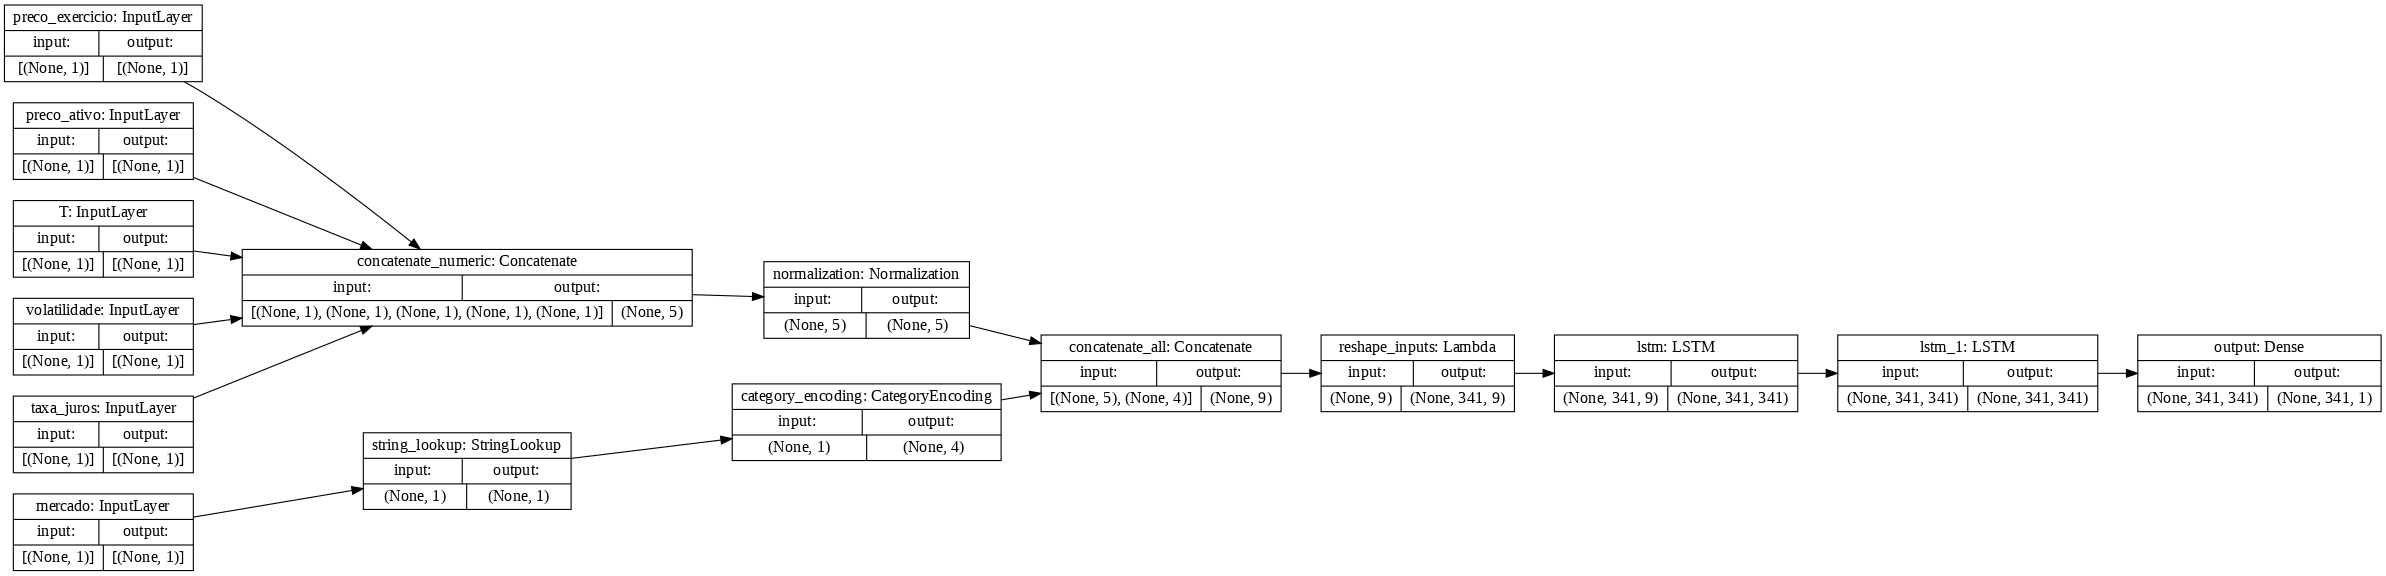

In [ ]:
#@title Model Subclassing
h = tf.keras.layers.LSTM(timestep_length, return_sequences=True)(reshape_inputs)
h = tf.keras.layers.LSTM(timestep_length, return_sequences=True)(h)
h = tf.keras.layers.Dense(120, activation='relu', name='dense_1')(h)
h = tf.keras.layers.Dense(120, activation='relu', name='dense_2')(h)
h = tf.keras.layers.Dense(120, activation='relu', name='dense_3')(h)
h = tf.keras.layers.Dense(120, activation='relu', name='dense_4')(h)
outputs = tf.keras.layers.Dense(1, name='output')(h)

# Create an instance of the model
model = tf.keras.Model(inputs, outputs)
tf.keras.utils.plot_model(model=model, rankdir="LR", dpi=80, show_shapes=True)

In [ ]:
#@title Inicialização do modelo
# Para apresentar o sumário do modelo, primeiramente, é necessário inicializar os pesos e bias de cada camada,
# isso é feito utilizando uma amostra dos dados
element = next(iter(train_ds.take(1)))[0]
model(element)

<tf.Tensor: shape=(64, 341, 1), dtype=float32, numpy=
array([[[-0.00118692],
        [-0.0037264 ],
        [-0.0076029 ],
        ...,
        [-0.07265304],
        [-0.06884394],
        [-0.06496174]],

       [[-0.00118692],
        [-0.0037264 ],
        [-0.0076029 ],
        ...,
        [-0.07198974],
        [-0.06804419],
        [-0.06404819]],

       [[-0.00118692],
        [-0.0037264 ],
        [-0.0076029 ],
        ...,
        [-0.07170097],
        [-0.06769361],
        [-0.0636455 ]],

       ...,

       [[-0.00062075],
        [-0.00308617],
        [-0.00777615],
        ...,
        [-0.09582771],
        [-0.09268663],
        [-0.08943231]],

       [[-0.00062075],
        [-0.00308617],
        [-0.00777615],
        ...,
        [-0.09059869],
        [-0.09059869],
        [-0.0917757 ]],

       [[-0.00062075],
        [-0.00308617],
        [-0.00777615],
        ...,
        [-0.0962496 ],
        [-0.09304752],
        [-0.08972975]]], dtype=float32)>

In [ ]:
#@title Sumário do modelo
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
preco_exercicio (InputLayer)    [(None, 1)]          0                                            
__________________________________________________________________________________________________
preco_ativo (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
T (InputLayer)                  [(None, 1)]          0                                            
__________________________________________________________________________________________________
volatilidade (InputLayer)       [(None, 1)]          0                                            
____________________________________________________________________________________________

In [ ]:
#@title Função de perda e otimizador
def custom_loss_mse(y_true, y_pred):
    weights = tf.where((y_true > 0), tf.ones_like(y_true), y_true)
    loss = tf.reduce_sum(tf.multiply(tf.pow((y_true - y_pred), 2), weights), axis=1)
    n = tf.reduce_sum(weights, axis=1)
    mse = tf.divide(loss, n)
    return tf.reduce_mean(mse)

def custom_metric_mae(y_true, y_pred):
    weights = tf.where((y_true > 0), tf.ones_like(y_true), y_true)
    loss = tf.reduce_sum(tf.multiply(tf.abs(y_true - y_pred), weights), axis=1)
    n = tf.reduce_sum(weights, axis=1)
    mae = tf.divide(loss, n)
    return tf.reduce_mean(mae)

loss_object = custom_loss_mse
optimizer = tf.keras.optimizers.Adamax(0.001)

In [ ]:
#@title Métricas
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_mae = tf.keras.metrics.MeanAbsoluteError(name='train_mae')
val_loss = tf.keras.metrics.Mean(name='test_loss')
val_mae = tf.keras.metrics.MeanAbsoluteError(name='test_mae')

metrics = [train_loss, train_mae, val_loss, val_mae]

In [ ]:
#@title Aplicando gradiente
@tf.function
def train_step(data, labels):
    with tf.GradientTape() as tape:
        predictions = model(data, training=True)
        loss = loss_object(predictions, labels)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_mae(labels, predictions)

In [ ]:
#@title Função de teste
@tf.function
def test_step(data, labels):
  predictions = model(data, training=False)
  v_loss = loss_object(labels, predictions)

  val_loss(v_loss)
  val_mae(labels, predictions)

In [ ]:
#@title Treinamento do modelo
epochs = 30

# Dicionário com as métricas
metric_dict = {
    'epoch': [],
    'loss': [],
    'mae': [],
    'val_loss': [],
    'val_mae': []
}

for epoch in range(epochs):
    # Re-inicia as métricas a cada época
    [metric.reset_states() for metric in metrics]

    for train_data, train_labels in train_ds:
        train_step(train_data, tf.cast(train_labels, tf.float32))

    for test_data, test_labels in test_ds:
        test_step(test_data, tf.cast(test_labels, tf.float32))

    metric_dict['epoch'].append(epoch)
    metric_dict['loss'].append(train_loss.result().numpy())
    metric_dict['mae'].append(train_mae.result().numpy())
    metric_dict['val_loss'].append(val_loss.result().numpy())
    metric_dict['val_mae'].append(val_mae.result().numpy())

    print(f"Epoch: {epoch + 1:2},\tloss: {train_loss.result():10.6f},\tmae: {train_mae.result():10.6f},\tval_loss: {val_loss.result():10.6f},\tval_mae: {val_mae.result():10.6f}")

Epoch:  1,	loss:   1.015807,	mae:   0.832675,	val_loss:  15.230679,	val_mae:   0.351557
Epoch:  2,	loss:   0.971069,	mae:   0.753723,	val_loss:  12.818440,	val_mae:   0.670074
Epoch:  3,	loss:   0.669680,	mae:   0.552478,	val_loss:  13.350331,	val_mae:   0.459612
Epoch:  4,	loss:   0.541123,	mae:   0.393717,	val_loss:  13.653854,	val_mae:   0.339433
Epoch:  5,	loss:   0.483463,	mae:   0.295602,	val_loss:  13.851196,	val_mae:   0.260280
Epoch:  6,	loss:   0.448912,	mae:   0.230096,	val_loss:  13.982193,	val_mae:   0.206558
Epoch:  7,	loss:   0.426000,	mae:   0.186118,	val_loss:  14.066757,	val_mae:   0.170448
Epoch:  8,	loss:   0.404989,	mae:   0.157106,	val_loss:  14.121449,	val_mae:   0.145834
Epoch:  9,	loss:   0.399051,	mae:   0.140263,	val_loss:  14.116230,	val_mae:   0.142984
Epoch: 10,	loss:   0.432955,	mae:   0.181564,	val_loss:  14.012412,	val_mae:   0.166630
Epoch: 11,	loss:   0.381826,	mae:   0.150932,	val_loss:  14.321809,	val_mae:   0.177877
Epoch: 12,	loss:   0.984737,	mae